In [ ]:
!pip install tensorflow
!pip install keras-tuner --upgrade

In [ ]:
# These are the libraries we are going to use
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

<ipython-input-2-a98b0d7154e5>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/CSE All-Share Historical Data.csv')

In [ ]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [ ]:
df.shape

(920, 7)

In [ ]:
df_closing = df['Price'].apply(lambda x : x.replace(',', '')).astype('float')
df_closing.head()

0    5561.28
1    5569.94
2    5587.36
3    5645.65
4    5695.69
Name: Price, dtype: float64

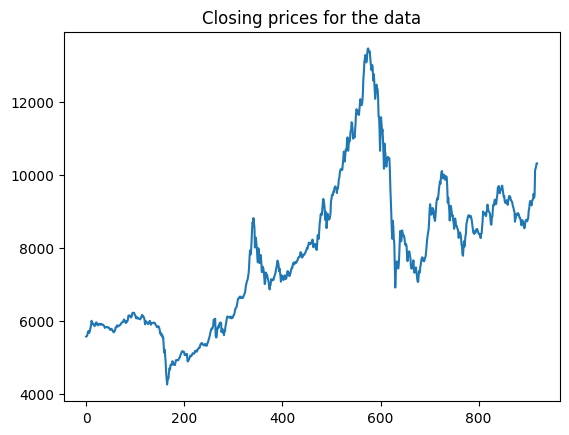

In [ ]:
plt.plot(df_closing.values);
plt.title("Closing prices for the data");

In [ ]:
# Scaling The Data
scaler=MinMaxScaler(feature_range=(0,1))
df_closing=scaler.fit_transform(np.array(df_closing).reshape(-1,1))

In [ ]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []

    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [ ]:
# Preparing train and test data

training_size=int(len(df_closing)*0.65)
test_size=len(df_closing)-training_size
train_data,test_data=df_closing[0:training_size,:],df_closing[training_size:len(df_closing),:1]

In [ ]:
#Taking data for past 100 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#LSTM model

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))

    for i in range(hp.Int('num_layers', 2, 15)):
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))

    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 2,
    executions_per_trial=3,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 2,
             validation_data=(X_test, ytest))

Search space summary
Default search space size: 11
layer1_units (Choice)
{'default': 10, 'conditions': [], 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
last_lstm_units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150], 'ordered': True}
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5, 0.6, 0.7], 'ordered': True}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units4 (Int)
{'default': No

In [ ]:
tuner.results_summary()

Results summary
Results in project/Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
layer1_units: 70
num_layers: 7
units0: 90
units1: 100
last_lstm_units: 50
rate: 0.7
units2: 40
units3: 100
units4: 100
units5: 20
units6: 10
Score: 0.07000777932504813

Trial 0 summary
Hyperparameters:
layer1_units: 100
num_layers: 6
units0: 90
units1: 50
last_lstm_units: 50
rate: 0.4
units2: 10
units3: 10
units4: 10
units5: 10
Score: 0.11194752901792526


In [ ]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 70)           20160     
                                                                 
 lstm_1 (LSTM)               (None, 100, 90)           57960     
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          76400     
                                                                 
 lstm_3 (LSTM)               (None, 100, 40)           22560     
                                                                 
 lstm_4 (LSTM)               (None, 100, 100)          56400     
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          80400     
                                                                 
 lstm_6 (LSTM)               (None, 100, 20)           9

In [ ]:
model_history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,ytest))

Epoch 1/100
16/16 [==============================] - 48s 1s/step - loss: 0.0332 - val_loss: 0.0109
Epoch 2/100
16/16 [==============================] - 13s 824ms/step - loss: 0.0198 - val_loss: 0.0270
Epoch 3/100
16/16 [==============================] - 13s 819ms/step - loss: 0.0187 - val_loss: 0.0100
Epoch 4/100
16/16 [==============================] - 13s 808ms/step - loss: 0.0137 - val_loss: 0.0111
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.0146 - val_loss: 0.0251
Epoch 6/100
16/16 [==============================] - 13s 808ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 7/100
16/16 [==============================] - 13s 801ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 8/100
16/16 [==============================] - 12s 773ms/step - loss: 0.0133 - val_loss: 0.0220
Epoch 9/100
16/16 [==============================] - 12s 715ms/step - loss: 0.0148 - val_loss: 0.0171
Epoch 10/100
16/16 [==============================] - 13s 797ms/step - loss: 0.0155 - va

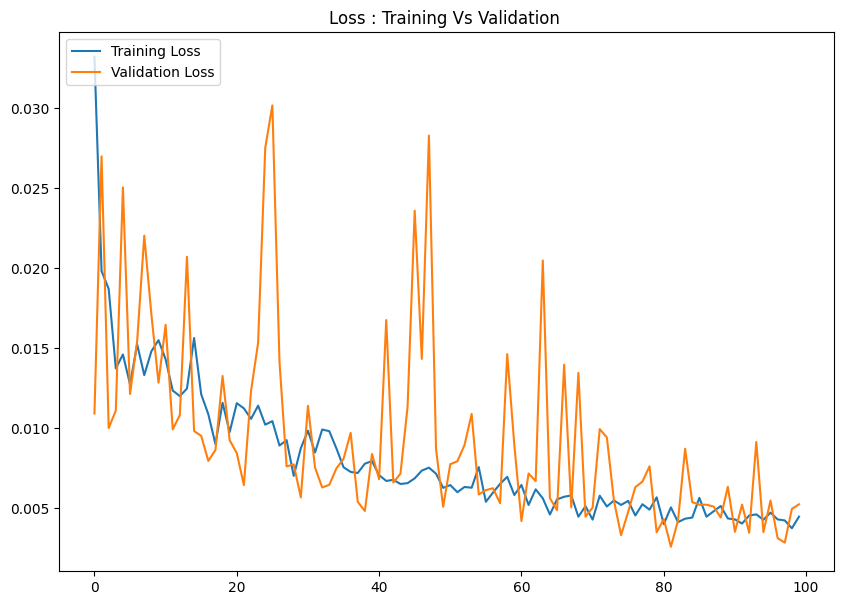

In [ ]:
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']



plt.figure(figsize=(10, 7));
plt.plot(range(100), loss, label='Training Loss');
plt.plot(range(100), validation_loss, label='Validation Loss');
plt.legend(loc='upper left');
plt.title('Loss : Training Vs Validation ');

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 1s 169ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

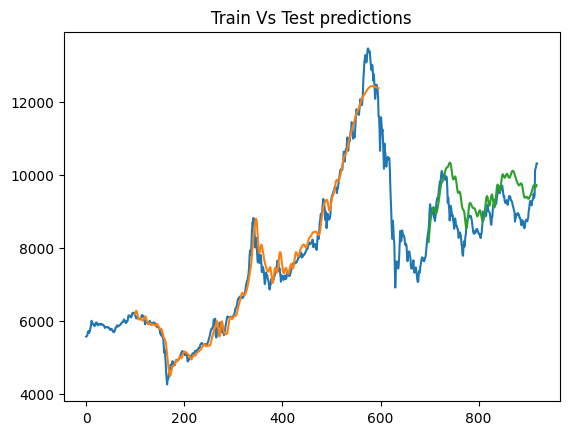

In [ ]:
look_back=100
trainPredictPlot = np.empty_like(df_closing)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_closing)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_closing)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df_closing))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Train Vs Test predictions');
plt.show()

#Predictions for next 10 days

In [ ]:
future_predictions = test_data.copy()
for i in range(100):
    new_prediction = model.predict(((future_predictions[341+i:])).reshape(1,100,1))
    future_predictions = np.append(future_predictions, new_prediction)

plt.plot(scaler.inverse_transform(future_predictions[441:].reshape(-1, 1)));
plt.title('Predictions for the next 10 days');
plt.xlabel('Days');
plt.ylabel('Closing stocks');

ValueError: ignored

In [ ]:
future_predictions = test_data.copy()
for i in range(100):
    start_index = 341 + i
    if start_index >= len(future_predictions):
        print(f"Error: Index {start_index} is out of range")
        break
    input_data = future_predictions[start_index:].reshape(1, 100, 1)
    new_prediction = model.predict(input_data)
    future_predictions = np.append(future_predictions, new_prediction)

if len(future_predictions) > 441:
    predictions_to_plot = scaler.inverse_transform(future_predictions[441:].reshape(-1, 1))
    plt.plot(predictions_to_plot)
    plt.title('Predictions for the next 10 days')
    plt.xlabel('Days')
    plt.ylabel('Closing stocks')
else:
    print("Error: Insufficient predictions to plot")


Error: Index 341 is out of range
Error: Insufficient predictions to plot


#Conclusion

In [ ]:
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(ytest,test_predict)))

Train RMSE:  7854.869152800851
Test RMSE:  9477.135048188678
